# Calibration (SIR model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.
To do this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SIR model.
Using the data after lockdown and the inferred parameters, we infer the change of the contact structure.

For the pre-intervention period, we infer the following parameters: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals),
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory

In [2]:
# population and age classes (4 age groups, UK contact structure)
M=4  # number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]
        
Ni = int(Ni/5e2) # Scale the numbers to avoid numerical problems
N = np.sum(Ni)

In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [4]:
T_intervention = 20
times= [T_intervention] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.04       # contact rate parameter
gIa   = 1./7       # recovery rate of asymptomatic infectives 
gIs   = 1./7       # recovery rate of symptomatic infectives 
alpha = 0.2        # asymptomatic fraction
fsa   = 0.8        # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10  #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
true_parameters = parameters
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, C, Tf, Nf)

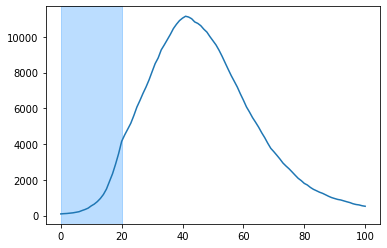

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.show() 

## 2) Infer the parameters of the model

-2104.1837893784627
0.3043956756591797


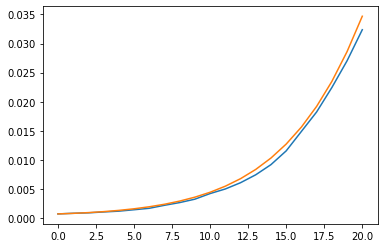

In [7]:
Tf = 20 # truncate to only getting the first few datapoints (up to lockdown) 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditons 
# They are likely to be different due to the inherent stochasticity of the model 
Tf_initial = T_intervention # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1
contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
xm = estimator.integrate(x[0], 0, Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [9]:
# take a guess 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.05
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds])

start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, generator.constant_CM, bounds=bounds, 
                             global_max_iter=20, eps=eps, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=965945, Thu May  7 17:33:58 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.912608757902738e+03 1.0e+00 8.95e-01  4e-02  1e-01 0:04.2
    2     32 -1.854167787567241e+03 1.5e+00 6.80e-01  2e-02  7e-02 0:08.0
    3     48 -2.020757843817390e+03 1.8e+00 5.67e-01  1e-02  6e-02 0:11.3
    5     80 -2.004476969046087e+03 2.4e+00 5.16e-01  1e-02  5e-02 0:16.9
    7    112 -2.078362786878100e+03 2.4e+00 5.23e-01  8e-03  5e-02 0:22.5
    9    144 -2.100364332166024e+03 4.3e+00 4.40e-01  5e-03  5e-02 0:28.2
   12    192 -2.104892950843058e+03 1.0e+01 4.36e-01  3e-03  6e-02 0:36.6
   15    240 -2.103965108115546e+03 1.5e+01 2.87e-01  1e-03  4e-02 0:45.2
   19    304 -2.109652388088170e+03 2.8e+01 3.22e-01  1e-03  6e-02 0:55.8
Optimal value (global minimisation):  -2109.6523880881696
Starting local minimisation...
Optimal value (local minimisation):  -2110.9032467

In [10]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(params)

True parameters:
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

Inferred parameters:
[0.21702363 0.03961161 0.17745551 0.13525521]


## 3) Infer the change of contact structure

In [11]:
aW_g = 0.6 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])
stds = np.array([0.1, 0.2, 0.15])

x = data['X']/N
x = x[22:]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-7588.841712913275


In [12]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
params = estimator.infer_control(guess, stds, x, Tf, Nf, generator, bounds,
                                 global_max_iter=20, eps=eps, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=992279, Thu May  7 17:35:09 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.409100042575408e+03 1.0e+00 1.06e+00  1e-01  2e-01 0:11.6
    2     32 -7.438110412726326e+03 1.3e+00 9.10e-01  8e-02  2e-01 0:22.7
    3     48 -7.477670745006492e+03 1.9e+00 7.57e-01  6e-02  2e-01 0:33.8
    4     64 -7.468768253502479e+03 2.4e+00 5.91e-01  5e-02  1e-01 0:45.0
    5     80 -7.474575638842020e+03 2.6e+00 6.12e-01  4e-02  9e-02 0:56.9
    6     96 -7.480815066411416e+03 2.6e+00 5.35e-01  3e-02  7e-02 1:08.3
    7    112 -7.477996242332376e+03 2.3e+00 4.08e-01  2e-02  4e-02 1:19.6
    8    128 -7.481123134293641e+03 2.2e+00 3.48e-01  2e-02  3e-02 1:30.6
    9    144 -7.481919333620318e+03 2.3e+00 3.69e-01  2e-02  3e-02 1:41.9
   10    160 -7.481317087900236e+03 2.7e+00 2.86e-01  1e-02  2e-02 1:53.1
   11    176 -7.481892390116841e+03 2.2e+00 2.15e-01  9e-03  1e-0

In [13]:
print("True lockdown factors:")
print([aW, aS, aO])

print("\nInferred lockdown factors:")
print(params)

True lockdown factors:
[0.5, 0.6, 0.6]

Inferred lockdown factors:
[0.53867039 0.60854092 0.6021929 ]
